<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Modeling and quantifying the river channel evolution with Landlab
These exercises are based on a project orginally designed by Kelin Whipple at Arizona State University. These exercises only model the fluvial part of the landscape.

<hr>
<small> For instructions on how to run an interactive IPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

** What is this notebook? **

This notebook illustrates the evolution of detachment-limited channels in an actively uplifting landscape. The landscape evolves according to the equation:

\begin{equation}
 \frac{\partial z}{\partial t} = -K_\text{sp} A^{m_{sp}} S^{n_{sp}} + U
\end{equation}
Here, $K_{sp}$ is the coefficient on fluvial incision, and $m_{sp}$ and $n_{sp}$ are positive exponents, usually thought to have a ratio, $m_{sp}/n_{sp} \approx 0.5$. $A$ is drainage area and $S$ is the slope of steepest descent ($-\frac{dz}{dx}$) where $x$ is horizontal distance (positive in the downslope direction) and $z$ is elevation. (If slope is negative there is no fluvial erosion.) $U$ is an externally-applied uplift field.

The fluvial erosion term is also known as the stream power equation. Before running this model you should be familiar with this equation from class lectures and reading.

** What will you do? **

In this exercise you will modify the code to get a better understanding of how rock uplift and erodibility control fluvial channel form.

Start at the top by reading each block of text and sequentially running each code block (shift - enter). 

Remember that you can always go to the _Kernel_ pulldown menu at the top and choose _Restart & Clear Output_ or _Restart & Run All_ if you change things and want to start afresh. If you just change one code block and rerun only that code block, only the parts of the code in that code block will be updated. (E.g. if you change parameters but don't reset the code blocks that initialize run time or topography, then these values will not be reset.)

** Now on to the code... **

First we have to import the parts of Python and Landlab that are needed to run this code. You should not have to change this first code block.

In [1]:
# Code block 1
import numpy as np
from landlab import RasterModelGrid
from landlab.components import StreamPowerEroder, FlowRouter
from landlab.components import ChiFinder, SteepnessFinder
from landlab.plot import channel_profile as prf
from landlab import imshow_grid
from copy import deepcopy
from matplotlib import pyplot as plt
from landlab.io import write_esri_ascii
#below is to make plots show up in the notebook
%matplotlib inline 

Make a grid and set boundary conditions. 

In [2]:
# Code Block 2
number_of_rows = 50 # number of raster cells in vertical direction (y)
number_of_columns = 100 # number of raster cells in horizontal direction (x)
dxy  = 200 # side length of a raster model cell, or resolution [m]

# Below is a raster (square cells) grid, with equal width and height 
mg = RasterModelGrid((number_of_rows,number_of_columns), dxy)

# Set boundary conditions - only the south side of the grid is open.
# Boolean parameters are sent to function in order of
# east, north, west, south.
mg.set_closed_boundaries_at_grid_edges(True, True, True, False)

Here we make the initial grid of elevation.

In [3]:
# Code Block 3

np.random.seed(35) # seed set to zero so our figures are reproducible
mg_noise = np.random.rand(mg.number_of_nodes)/1000. # intial noise on elevation gri

# set up the elevation on the grid
zr = mg.add_zeros('node', 'topographic__elevation')
zr += mg_noise

sf = SteepnessFinder(mg, reference_concavity=0.5, min_drainage_area=1000.)
cf = ChiFinder(mg, min_drainage_area=1000., reference_concavity=0.5, use_true_dx=True)

Set parameters related to time.

In [20]:
# Code Block 4

tmax = 1E5  # time for the model to run [yr] (Original value was 5E5 yr)
dt = 50000 # time step [yr]
total_time = 0 # amount of time the landscape has evolved [yr]

t = np.arange(0, tmax, dt) # each of the time steps that the code will run

Set parameters for incision and intializing all of the process components that do the work.

In [5]:
# Code Block 5

# Original K_sp value is 1e-5
K_sp = 1.E-5  # units vary depending on m_sp and n_sp 
m_sp = 0.5 # exponent on drainage area in stream power equation
n_sp = 1.0 # exponent on slope in stream power equation

frr = FlowRouter(mg) # intializing flow routing
spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0,
                        use_Q=None) #initializing stream power incision

Initialize rock uplift rate. This will need to be changed later.

In [21]:
# Code Block 6

#  uplift_rate [m/yr] (Original value is 0.0001 m/yr)
uplift_rate = np.ones(mg.number_of_nodes)*0.0001 

## If you want to add a one-time event that uplifts only part of the 
## landscape, uncomment the 3 lines below
fault_location = 4000  # [m]
uplift_amount = 10 # [m]
zr[np.where(mg.node_y>fault_location)] += uplift_amount 

## IMPORTANT! To use this fault generator, comment the one-time 
## uplift event above if it isn't already commented out.
## Code below creates a fault horizontally across the grid.
## Uplift rates are greater where y values  > fault location.
## To use, uncomment the 5 code lines below and edit to your values
#fault_location = 4000  # [m]
#low_uplift_rate = 0.0001 # [m/yr]
#high_uplift_rate = 0.0004 # [m/yr]
#uplift_rate[np.where(mg.node_y<fault_location)] = low_uplift_rate
#uplift_rate[np.where(mg.node_y>fault_location)] = high_uplift_rate

## IMPORTANT! To use this fault generator, comment the one-time 
## uplift event above if it isn't already commented out.
## If you want a linear gradient in uplift rate 
## (increasing uplift into the range),
## uncomment the 4 code lines below and edit to your values.
#low_uplift_rate = 0.0001 # [m/yr]
#high_uplift_rate = 0.004 # [m/yr]
## below is uplift gradient per node row index, NOT row value in meters
#uplift_rate_gradient = (high_uplift_rate - low_uplift_rate)/(number_of_rows-3)
#uplift_rate = low_uplift_rate + ((mg.node_y / dxy)-1) * uplift_rate_gradient

Now for the code loop. 

Note that you can rerun Code Block 7 many times, and as long as you don't reset the elevation field (Code Block 3), it will take the already evolved landscape and evolve it even more. If you want to change parameters in other code blocks (e.g. Code Block 5 or 6), you can do that too, and as long as you don't reset the elevation field (Code Block 4) the new parameters will apply on the already evolved topography. 

In [22]:
# Code Block 7

for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt # uplift the landscape
    frr.run_one_step() # route flow
    spr.run_one_step(dt) # fluvial incision
    total_time += dt # update time keeper
    print total_time

50000
100000


Plot the topography.

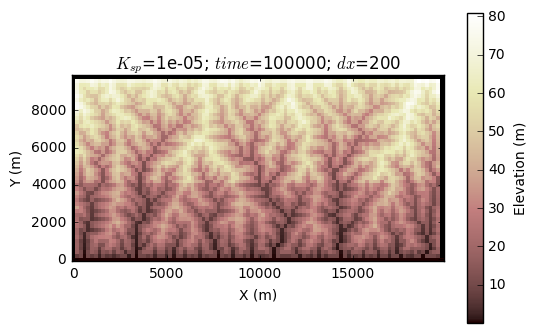

In [23]:
# Code Block 8

imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'),
                var_name='Elevation (m)')
title_text = '$K_{sp}$='+str(K_sp) + '; $time$='+str(total_time) + '; $dx$='+str(dxy)
plt.title(title_text)

Plot the slope and area data at each point on the landscape (in log-log space).

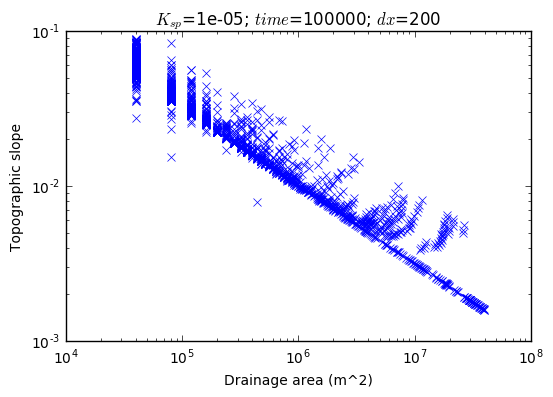

In [24]:
# Code Block 9
edge = np.unique(mg.neighbors_at_node[mg.boundary_nodes, :])
not_edge = np.in1d(mg.nodes.flatten(), edge, assume_unique=True,
                       invert=True)
plt.loglog(mg.at_node['drainage_area'][not_edge],
           mg.at_node['topographic__steepest_slope'][not_edge], 'x')
#xlim([1.e3, 1.e7])
plt.ylabel('Topographic slope')
plt.xlabel('Drainage area (m^2)')
plt.title(title_text)

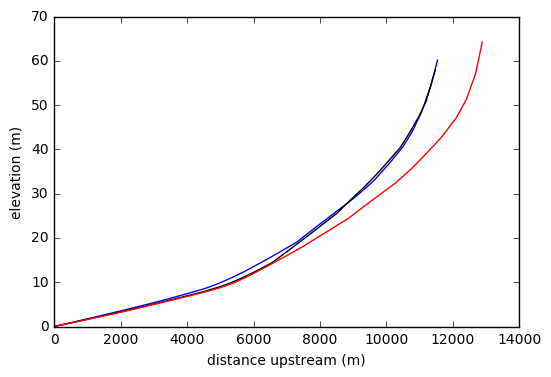

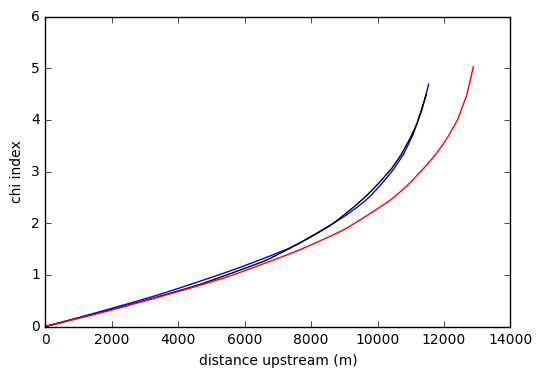

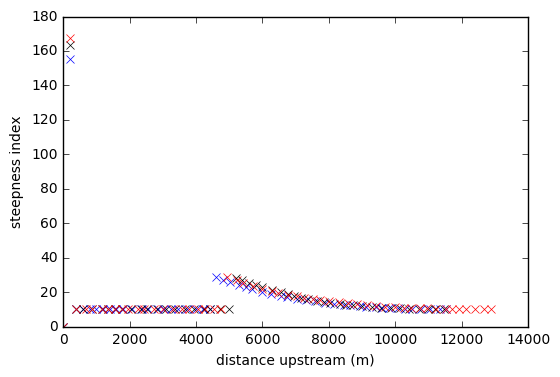

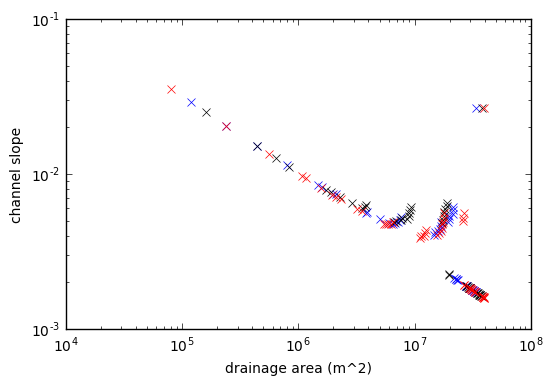

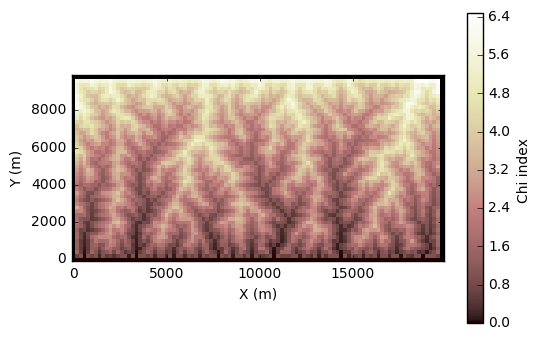

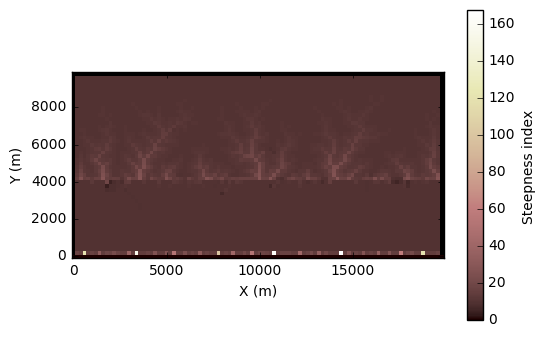

In [26]:
profile_IDs = prf.channel_nodes(mg, mg.at_node['topographic__steepest_slope'],
                                mg.at_node['drainage_area'],
                                mg.at_node['flow__receiver_node'],
                                number_of_channels=3)

dists_upstr = prf.get_distances_upstream(
    mg, len(mg.at_node['topographic__steepest_slope']),
    profile_IDs, mg.at_node['flow__link_to_receiver_node'])

plt.figure(1)
plt.plot(dists_upstr[0], zr[profile_IDs[0]], 'b-')
plt.plot(dists_upstr[1], zr[profile_IDs[1]], 'k-')
plt.plot(dists_upstr[2], zr[profile_IDs[2]], 'r-')
plt.xlabel('distance upstream (m)')
plt.ylabel('elevation (m)')

cf.calculate_chi()
sf.calculate_steepnesses()
plt.figure(2)
plt.plot(dists_upstr[0], mg.at_node['channel__chi_index'][profile_IDs[0]], 'b-')
plt.plot(dists_upstr[1], mg.at_node['channel__chi_index'][profile_IDs[1]], 'k-')
plt.plot(dists_upstr[2], mg.at_node['channel__chi_index'][profile_IDs[2]], 'r-')
plt.xlabel('distance upstream (m)')
plt.ylabel('chi index')

plt.figure(3)
plt.plot(dists_upstr[0], mg.at_node['channel__steepness_index'][profile_IDs[0]], 'bx')
plt.plot(dists_upstr[1], mg.at_node['channel__steepness_index'][profile_IDs[1]], 'kx')
plt.plot(dists_upstr[2], mg.at_node['channel__steepness_index'][profile_IDs[2]], 'rx')
plt.xlabel('distance upstream (m)')
plt.ylabel('steepness index')

plt.figure(4)
plt.loglog(mg.at_node['drainage_area'][profile_IDs[0]],
           mg.at_node['topographic__steepest_slope'][profile_IDs[0]], 'bx')
plt.loglog(mg.at_node['drainage_area'][profile_IDs[1]],
           mg.at_node['topographic__steepest_slope'][profile_IDs[1]], 'kx')
plt.loglog(mg.at_node['drainage_area'][profile_IDs[2]],
           mg.at_node['topographic__steepest_slope'][profile_IDs[2]], 'rx')
plt.xlabel('drainage area (m^2)')
plt.ylabel('channel slope')

plt.figure(5)
imshow_grid(mg, 'channel__chi_index', grid_units=('m', 'm'),
                var_name='Chi index ')


plt.figure(6)
imshow_grid(mg, 'channel__steepness_index', grid_units=('m', 'm'),
                var_name='Steepness index ')

** When you have a grid that you want to export, run the code block below.**

In [11]:
# Code Block 10

## Below has the name of the file that data will be written to.
## You need to change the name of the file every time that you want
## to write data, otherwise you will get an error.
## This will write to the directory that you are running the code in.
#write_file_name = 'data.txt'
## Below is writing elevation data in the ESRI ascii format so that it can
## easily be read into Arc GIS or back into Landlab.
#write_esri_ascii(write_file_name, mg, 'topographic__elevation')

Answer the following questions using the code above. All answers should be typed, and supporting figures (produced using the code) should be embedded in one document that you hand in. (Download or screenshoot the figures.) Anything with a question mark should be answered in the document that you hand in. 

1. **Steady state with low uplift rate. ** Using the parameters provided in the initial notebook, run the landscape to steady state. How did you know that the landscape reached steady state? Note the approximate time that it took to reach steady state. Include plots of the steady-state landscape and slope-area relationship. (If you want to analyze these landscapes outside of Landlab or save for later, make sure you save the elevation data to a text file (Code Block 10).)

2. **Transient landscape responding to an increase in rock uplift. ** Use the steady-state landscape that you generated in the first question, and increase rock uplift uniformly by a factor of 4 (Code Block 6). Before running this, make sure that you also reduce _tmax_ to 1e5 yrs (Code Block 4). Run this until the maximum elevation in the grid is ~ 170 m. (If you want to save these landscapes for later, make sure you save the elevation data to a text file (Code Block 10).)

3. ** Steady-state landscape with increased rock uplift. ** Now run the landscape from question 2 until it reaches steady state. 

4. ** Increase erodibility. ** Use the steady-state landscape from question 3, and now double erodibility ($K_{sp}$ = 2E-5, Code Block 5). Set tmax to 1e5 yrs (Code Block 4). Run for 1e5 yrs and save plots of the topography and slope-area relationship. Run for another 1e5 yrs and save the plots again. Now run for 5e5 yrs and save plots of the topography and slope-area relationship. What could cause a uniform increase in erodibility? Describe how the landscape evolves in response to the increase in erodibility. 

5. ** Spatially varible uplift - discrete, massive earthquake. ** (First recreate the steady-state landscape with low uplift rate (uniform at 1e-4 m/yr) and low erodbility ($K_{sp}$ = 1E-5, i.e. setting in question 1.) Now add a seismic event - a fault that runs horizontally across the landscape at y = 4000 m, and instantaneously uplifts half the landscape by 10 meters (Code Block 6). In this case, we will keep background uplift uniform. Set tmax to 1e5 yrs (Code Block 4). Now run the time loop four times and look at the topography after each loop. How does the landscape respond to this fault. 

6. ** Spatially Varible Uplift - discrete fault with two different uplift rates. ** (First recreate the steady-state landscape with low uplift rate (uniform at 1e-4 m/yr) and low erodbility ($K_{sp}$ = 1E-5, i.e. setting in question 1.) Now we will add a fault (at y = 4000 m) in which the uplift rate on the footwall is higher (0.0004 m/yr) than on the hanging wall (uplift rate = 0.0001 m/yr). (Edit Code Block 6.) Set tmax to 1e5 yrs (Code Block 4) before you start running the time loop. Now run the time loop four separate times and look at the topography after each loop. How does the landscape respond to this fault?

7. ** Spatially Varible Uplift - gradient in uplift across the range. ** (First recreate the steady-state landscape with low uplift rate (uniform at 1e-4 m/yr) and low erodbility ($K_{sp}$ = 1E-5, i.e. setting in question 1.) Now we will add a linear gradient in uplift rate across the entire range (edit Code Block 6). The maximum uplift rate will be 0.0004 m/yr at the core of the range, and 0.0001 m/yr at the front of the range. Set tmax to 1e5 yrs (Code Block 4) before you start running the time loop. Now run the time loop four separate times and look at the topography after each loop. How does the landscape respond to this gradient in uplift rate?